In [38]:
import torch
import transformers
import json

In [39]:
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
model = transformers.RobertaModel.from_pretrained('roberta-base')

In [40]:
torch.cuda.set_device(0)

In [41]:
with open("../data/truism_data/physical_data_sentences_2.json") as f:
    sentences = json.load(f)

In [42]:
model.cuda()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [127]:
output = {
    "label" : [],
    "feature" : []
}

output_2 = {}
with torch.no_grad():
    for key in sentences:
        output_2[int(key)] = []
        for perturb in sentences[key]:
            for asym in sentences[key][perturb]:
                sentence = sentences[key][perturb][asym]
                input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).cuda().unsqueeze(0)
                outputs = model(input_ids)
                cls_hidden_state = outputs[0][0][0].cpu().detach().numpy()
                output["label"].append(int(key))
                output["feature"].append(cls_hidden_state)
                output_2[int(key)].append(cls_hidden_state)
                
                

In [128]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

In [129]:
output_df = pd.DataFrame.from_dict(output)

In [131]:
def within_ss(cluster, center):
    return np.sum(np.square(cluster - center))

#Total sum of squares (all vectors are in one cluster)
sst = within_ss(list(output_df["feature"]), np.mean(list(output_df["feature"]), axis=0))

#Sum of squares within each cluster
ssw = 0
for label in range(0,20):
    cluster_vectors = list(output_df[output_df["label"] == label]["feature"])
    ssw += within_ss(cluster_vectors, np.mean(cluster_vectors, axis=0))
# Sum of sqaures between clusters
ssb = sst - ssw

In [132]:
sst

52.823166

In [133]:
ssw

19.596595972776413

In [134]:
ssb

33.226569920778275

In [160]:
def compute_cosines(i, j, data):
    cosines = []
    for k in range(len(data[i])):
        for l in range(len(data[j])):
            if k == l and i == j:
                continue
            else:
                cosines.append(-1*(cosine(data[i][k], data[j][l]) - 1))
    
    return np.mean(cosines)

In [164]:
cos_matrix = np.array([np.array([0]*20, dtype=float)]*20, dtype=float)

In [165]:
for i in range(20):
    for j in range(20):
        cos_matrix[i][j] = compute_cosines(i, j, output_2)

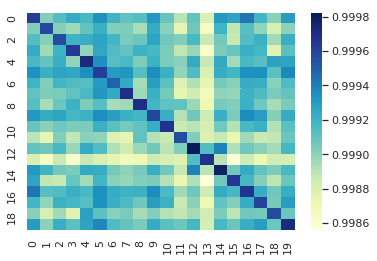

In [166]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()
ax = sns.heatmap(cos_matrix, cmap="YlGnBu")
plt.show()